**Preparing Mock Data**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate mock transaction data
np.random.seed(42)
num_transactions = 5000
num_customers = 500
products = [f'Prod_{100+i}' for i in range(20)]
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)
date_range_days = (end_date - start_date).days

# Customer spending profiles
customer_profiles = {
    f'CUST{1000+i}': {
        'avg_spend': np.random.uniform(10, 200),
        'frequency_factor': np.random.uniform(0.1, 1)
    }
    for i in range(num_customers)
}

transaction_data = []

for i in range(num_transactions):
    customer_id = f'CUST{1000 + np.random.randint(0, num_customers)}'
    transaction_date = start_date + timedelta(days=np.random.randint(0, date_range_days))
    num_items_in_transaction = np.random.randint(1, 6)

    for item in range(num_items_in_transaction):
        product_id = np.random.choice(products)
        quantity = np.random.randint(1, 4)

        # Tie price to customer profile somewhat
        unit_price = np.random.uniform(5, 100) * (customer_profiles[customer_id]['avg_spend'] / 50)
        unit_price = round(max(1.0, unit_price), 2)

        transaction_data.append({
            'TransactionID': f'TRX{50000+i}_{item}',
            'CustomerID': customer_id,
            'TransactionDate': transaction_date.strftime('%Y-%m-%d'),
            'ProductID': product_id,
            'Quantity': quantity,
            'UnitPrice': unit_price
        })

# Create DataFrame
df_transactions = pd.DataFrame(transaction_data)
df_transactions['TotalPrice'] = df_transactions['Quantity'] * df_transactions['UnitPrice']

In [2]:
# Save to CSV
df_transactions.to_csv('customer_transactions_mock_data.csv', index=False)
print("Mock customer transaction data generated: customer_transactions_mock_data.csv")

Mock customer transaction data generated: customer_transactions_mock_data.csv


In [ ]:
from google.colab import files
files.download('customer_transactions_mock_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Loading Data and Preperation**

In [3]:
df_transactions = pd.read_csv("/content/customer_transactions_mock_data.csv")
df_transactions.head()

,TransactionID,CustomerID,TransactionDate,ProductID,Quantity,UnitPrice,TotalPrice
0,TRX50000_0,CUST1302,2022-01-12,Prod_107,3,53.74,161.22
1,TRX50000_1,CUST1302,2022-01-12,Prod_104,2,43.15,86.30
2,TRX50000_2,CUST1302,2022-01-12,Prod_107,1,59.80,59.80
3,TRX50001_0,CUST1267,2023-10-17,Prod_108,1,214.31,214.31
4,TRX50001_1,CUST1267,2023-10-17,Prod_109,3,312.02,936.06


In [4]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    15143 non-null  object 
 1   CustomerID       15143 non-null  object 
 2   TransactionDate  15143 non-null  object 
 3   ProductID        15143 non-null  object 
 4   Quantity         15143 non-null  int64  
 5   UnitPrice        15143 non-null  float64
 6   TotalPrice       15143 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 828.3+ KB


In [5]:
df_transactions.isnull().sum()

,0
TransactionID,0
CustomerID,0
TransactionDate,0
ProductID,0
Quantity,0
UnitPrice,0
TotalPrice,0


In [6]:
df_transactions.describe()

,Quantity,UnitPrice,TotalPrice
count,15143.000000,15143.000000,15143.000000
mean,1.998349,103.732894,207.328918
std,0.818851,85.986186,203.743701
min,1.000000,1.220000,1.540000
25%,1.000000,34.010000,58.740000
50%,2.000000,76.970000,137.970000
75%,3.000000,154.180000,285.340000
max,3.000000,393.870000,1181.610000


In [7]:
# Here we will change TransactionDate to datetime
df_transactions['TransactionDate'] = pd.to_datetime(df_transactions['TransactionDate'])
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    15143 non-null  object        
 1   CustomerID       15143 non-null  object        
 2   TransactionDate  15143 non-null  datetime64[ns]
 3   ProductID        15143 non-null  object        
 4   Quantity         15143 non-null  int64         
 5   UnitPrice        15143 non-null  float64       
 6   TotalPrice       15143 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 828.3+ KB


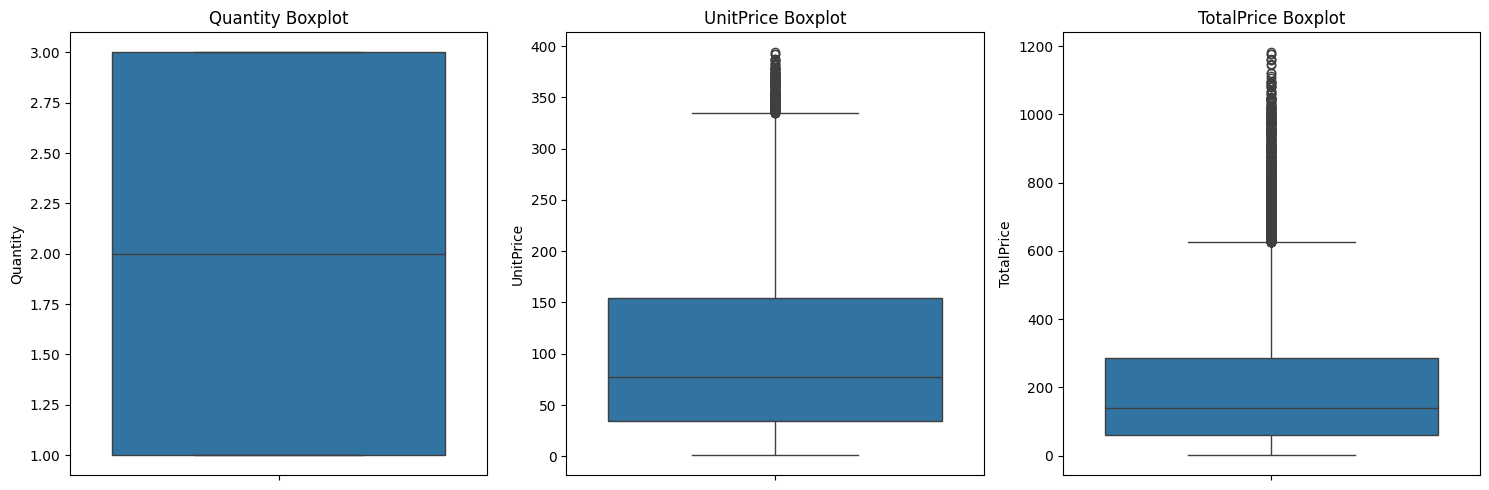

In [8]:
# Checking Outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

for i, column in enumerate(['Quantity', 'UnitPrice', 'TotalPrice']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df_transactions[column])
    plt.title(f'{column} Boxplot')

plt.tight_layout()
plt.show()

In [9]:
# Removing Outliers
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply to mock data
df_clean = remove_outliers_iqr(df_transactions, ['Quantity', 'UnitPrice', 'TotalPrice'])

In [10]:
print(f"Original records: {len(df_transactions)}")
print(f"After outlier removal: {len(df_clean)}")

Original records: 15143
After outlier removal: 14137


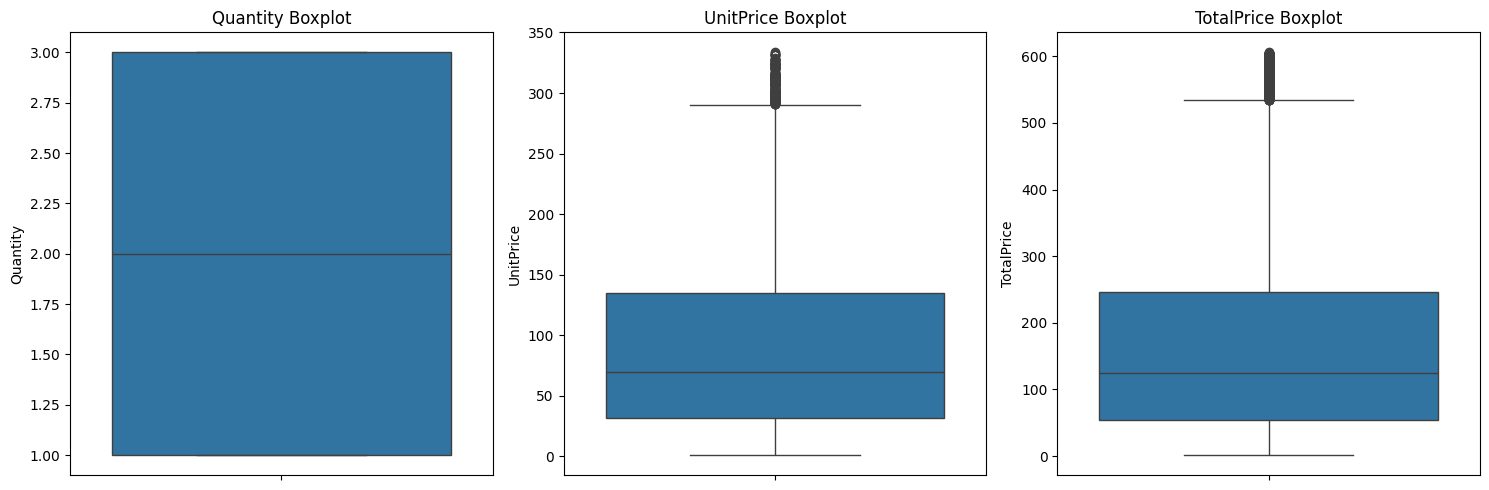

In [11]:
plt.figure(figsize=(15, 5))

for i, column in enumerate(['Quantity', 'UnitPrice', 'TotalPrice']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df_clean[column])
    plt.title(f'{column} Boxplot')

plt.tight_layout()
plt.show()

In [12]:
# RFM Calculation
snapshot_date = df_transactions['TransactionDate'].max() + timedelta(days=1)

# RFM table creation
rfm = df_transactions.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('TransactionID', 'count'),
    MonetaryValue=('TotalPrice', 'sum')
).reset_index()

rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,CUST1000,9,41,6855.79
1,CUST1001,49,10,2856.43
2,CUST1002,7,25,2175.73
3,CUST1003,22,33,1085.57
4,CUST1004,134,27,6887.81


**Exploratory Data Analysis and Feature Scaling**

In [13]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,500.000000,500.000000,500.0000
mean,71.310000,30.286000,6279.1636
std,65.035075,10.224543,4430.0027
min,1.000000,4.000000,377.0000
25%,22.000000,23.000000,2579.4425
50%,54.000000,30.000000,5292.9750
75%,105.250000,37.000000,9319.3500
max,500.000000,57.000000,20453.5000


In [14]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     500 non-null    object 
 1   Recency        500 non-null    int64  
 2   Frequency      500 non-null    int64  
 3   MonetaryValue  500 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 15.8+ KB


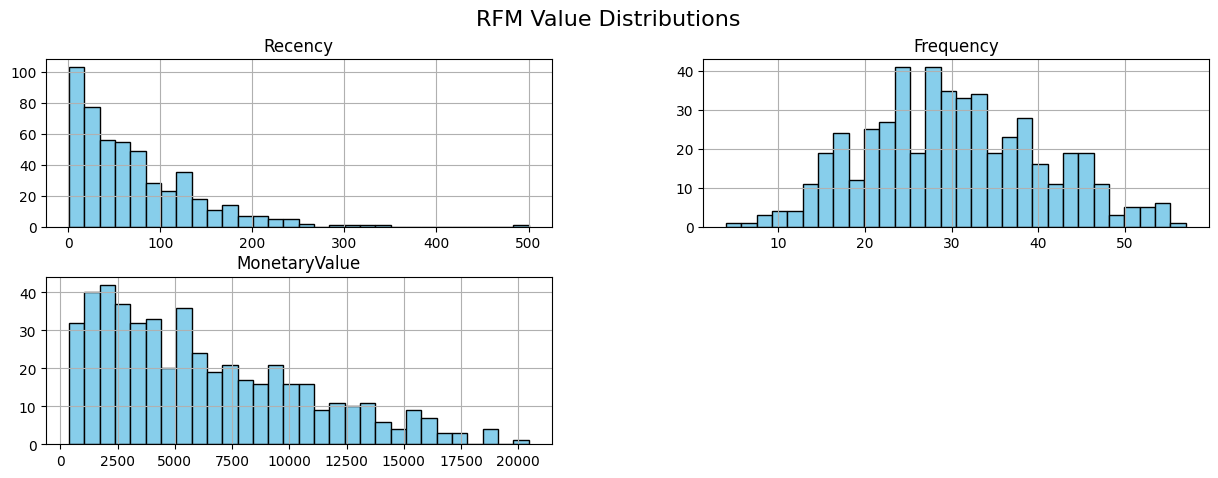

In [15]:
rfm[['Recency', 'Frequency', 'MonetaryValue']].hist(
    bins=30, figsize=(15, 5), color='skyblue', edgecolor='black'
)
plt.suptitle("RFM Value Distributions", fontsize=16)
plt.show()

In [16]:
rfm[['Recency', 'Frequency', 'MonetaryValue']].skew()

,0
Recency,1.647826
Frequency,0.207320
MonetaryValue,0.790106


In [17]:
# Lets apply log transformation to handle skewness on recency and monetaryvalue
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['MonetaryValue'] = np.log1p(rfm_log['MonetaryValue'])

In [18]:
# Scaling Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'MonetaryValue']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'MonetaryValue'])
rfm_scaled.head()

,Recency,Frequency,MonetaryValue
0,-1.311601,1.048920,0.458701
1,0.107585,-1.986037,-0.562686
2,-1.508367,-0.517509,-0.880192
3,-0.577150,0.265706,-1.690935
4,0.983425,-0.321705,0.464138


**Clustering**

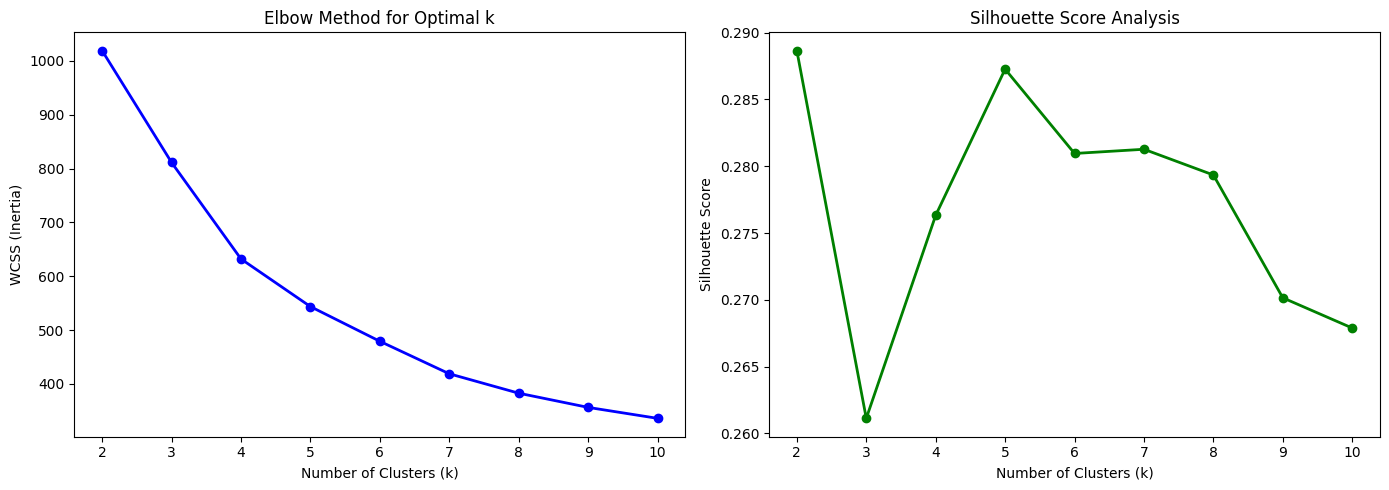

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Range for k values
K = range(2, 11)
wcss = []
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bo-', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.cluster import KMeans

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_scaled['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Optional: View cluster centers (scaled values)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_,
                               columns=['Recency', 'Frequency', 'MonetaryValue'])
print("Cluster Centers (Scaled):")
print(cluster_centers)

# View sample with cluster labels
rfm_scaled.head()


Cluster Centers (Scaled):
    Recency  Frequency  MonetaryValue
0  0.299000  -0.777288      -1.428374
1  0.627663  -0.451469       0.308650
2  0.085361   1.200223       0.681218
3 -1.505527  -0.036991       0.022277


,Recency,Frequency,MonetaryValue,Cluster
0,-1.311601,1.048920,0.458701,3
1,0.107585,-1.986037,-0.562686,0
2,-1.508367,-0.517509,-0.880192,3
3,-0.577150,0.265706,-1.690935,0
4,0.983425,-0.321705,0.464138,1


In [22]:
# Final Segment Names Summary
# Cluster	Segment Name
# 0	Low-Value Drop-offs
# 1	Occasional Spenders
# 2	Loyal High Spenders
# 3	At-Risk Former Customers

In [23]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------#
